In [61]:
# Libraries
import random
import numpy as np
import time
import matplotlib.pyplot as plt

In [304]:
# Get the data
def readMwcnf(mwcnfFile):
    weights = {} # dictionary for weights
    clauses = [] # list of clauses
    num = 0 # number of variables
    numC = 0 # number of clauses
 
    with open(mwcnfFile) as f:
        rawData = f.readlines()
        count = 0
        flag = False
        for data in rawData: 
            if("p mwcnf" in data):
                flag = True
            if flag: 
                line = data.strip(" ").strip("0").strip("\n").split(" ")
                if(line[0] == "p"):
                    num = int(line[-2])
                    numC = int(line[-1])
                elif(line[0] == "w"):
                    for i,w in enumerate(line[:-1]): weights[i] = w
                elif not ('c' in line) and len(line)>1:
                    clauses.append([int(x) for x in line[:-1]])
            
    return clauses, num, weights

# Genetic Algortihm
def geneticAlgorithm(clauses, numV, weights, solution, name):
    
    initialPopulation = randomPopulation(numV, populationSize)
    population = [(ind, fitness(ind, weights, clauses)) for ind in initialPopulation]
    x = []
    y1 = []
    y2 = []
    
    for i in range(generations):
        ac = average_error_clauses(population, len(clauses))
        aw = average_error_weights(population, solution)
        print(f"Average clauses and weights error over population: {ac:.3f}  -- {aw:.3f} ", end="\r")
        x.append(i)
        y1.append(ac)
        y2.append(aw)
        population = nextGeneration(population, weights, len(clauses), clauses)
        
    # Return solution found if exists
    population = sorted(population, key=lambda i: (i[1][0],i[1][1]), reverse=True)

    # Plot graph with trend line
    np_x = np.array(x)
    np_y1 = np.array(y1)
    np_y2 = np.array(y2)
    fig, ax = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
    # clauses error
    z = np.polyfit(x, np_y1, 1)
    p = np.poly1d(z)
    ax[0].plot(x,p(x),"r--")
    ax[0].plot(x, np_y1)
    ax[0].set_title('Clauses', fontsize=12)
    # weights error
    z = np.polyfit(x, np_y2, 1)
    p = np.poly1d(z)
    ax[1].plot(x,p(x),"r--")
    ax[1].plot(x, np_y2)
    ax[1].set_title('Weights', fontsize=12)
    
    fig.text(0.5, 0.04, 'Generations', ha='center', fontsize=14)
    fig.text(0.04, 0.5, 'Average errors of '+name, va='center', rotation='vertical', fontsize=14)
    fig.savefig(''+name, dpi=300, bbox_inches="tight")
    
    
    if(population[0][1][0]!=len(clauses)):
        print()
        print("NO SOLUTION FOUND, best parameters reached: " + str(population[0][1]))
        return (solution-population[0][1][1])/solution
    else:
        print()
        return (solution-population[0][1][1])/solution
    
    

# Random population
def randomPopulation(indSize, popSize):
    res = []
    for _ in range(popSize):
        temp = []
        for n in range(1,indSize+1):
            sign = random.randint(0,1)
            if sign:
                temp.append(n)
            else: 
                temp.append(-n)
        res.append(temp)
    
    return res

# Count the number of satisfied clauses
def num_satisfied_clauses(clauses,individual):
    dicts = {}
    for i in individual:
        if i<0:
            dicts[i*-1] = False
        else:
            dicts[i] = True
    
    num = 0
    for cl in clauses:
        t = 0
        for c in cl:
            if c<0:
                t = t + (not dicts[int(c)*-1])
            else:
                t = t + dicts[int(c)]
        
        if(t!=0):
            num+=1
    
    return num

# Compute fitness
def fitness(individual, weights, clauses):
    
    numClauses = num_satisfied_clauses(clauses,individual)
    
    sumWeights = 0
    for i in individual:
        if i > 0:
            sumWeights += int(weights[i])
            
    return (numClauses, sumWeights)

# Create next generation
def nextGeneration(population, weights, numClauses, clauses):
    next_gen = []
    
    eliteParents, parents = selection(population)
    next_gen = next_gen + eliteParents
    
    while len(next_gen) < len(population):
        
        random.shuffle(parents)
        tempP = [parents[0], parents[1]]
        children = []
        
        children = crossover(tempP, weights, clauses)

        # mutation
        mutate(children)

        next_gen = next_gen + children

    return next_gen
    

# Perform selection and elitism
def selection(population):
    
    eliteP = []
    parents = []
    
    # Elitism: sort and get the fittest ones
    population = sorted(population, key=lambda i: (i[1][0],i[1][1]), reverse=True)
    eliteP = eliteP + population[:round(elitismRate*populationSize)]
    
    # Select individuals
    copy = population[round(elitismRate*populationSize):].copy()
    for _ in range(int(0.6*populationSize)):
        
        # Shuffle the list to have random picks
        random.shuffle(copy)
        
        # Take k random individuals and select the best one
        tempList = []
        tempList = copy[0:k]
        tempList = sorted(tempList, key=lambda i: (i[1][0],i[1][1]), reverse=True)
        copy.remove(tempList[0])
        parents.append(tempList[0])
            
    return eliteP, parents

# Crossover from parents
def crossover(parents, weights, clauses):
    N = len(weights)-1
    i = random.randint(1,N)
    p1 = parents[0][0].copy()
    p2 = parents[1][0].copy()
    # extract the sign
    p1 = list(map(convert, p1))
    p2 = list(map(convert, p2))
    # actual crossover
    newSigns1 = p1[:i] + p2[i:]
    newSigns2 = p1[i:] + p2[:i]
    # multiply signs and absolute values
    bits1 = [n1*abs(n2) for n1,n2 in zip(newSigns1,parents[0][0])]
    bits2 = [n1*abs(n2) for n1,n2 in zip(newSigns2,parents[1][0])]
    child1 = (bits1, fitness(bits1, weights, clauses))
    child2 = (bits2, fitness(bits2, weights, clauses))
    
    return [child1, child2] 

# Util function for crossover
def convert(n):
    if n > 0:
        return 1
    else :
        return -1
    
# Mutation
def mutate(population):
   
    for individual in population:
        for i in range(len(individual[0])):
            if random.random() < mr:
                # Random bit
                bit = random.randint(0,len(individual[0])-1)
                # Flip it
                individual[0][bit] *= -1
                
# Statistic
def average_error_weights(population, solution):
    
    sumV = 0
    for p in population:
        sumV += (solution - p[1][1])/solution
    
    return sumV/len(population)

def average_error_clauses(population, numC):
    
    sumC = 0
    for p in population:
        sumC += (numC - p[1][0])/numC
    
    return sumC/len(population)
   

In [401]:
# Parameters

generations = 300 # number of epochs/generations
populationSize = 90 # population size
k = 25 # tournament size (determines the selection pressure)
mr = 0.05 # mutation rate
elitismRate = 5/populationSize # fraction of population that gets copied to the next generation

Average clauses and weights error over population: 0.113  -- 0.488 
NO SOLUTION FOUND, best parameters reached: (193, 11224)
Error of best solution found: 18.14 %


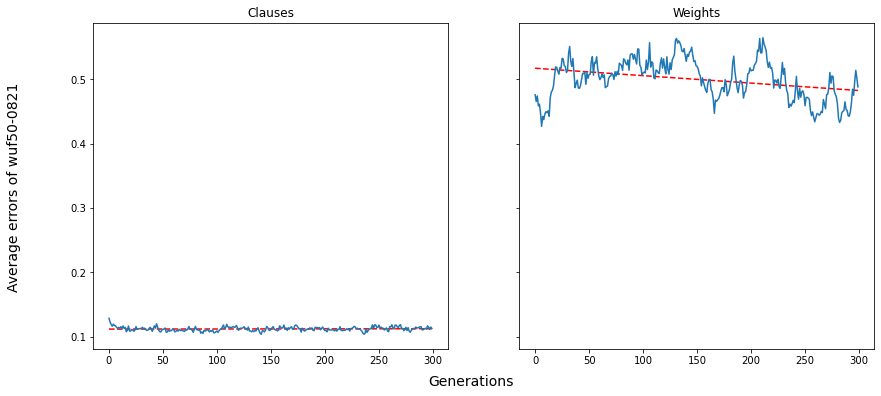

In [420]:

# get data
dataFile = "wuf-M/wuf20-78-M1/wuf20-010.mwcnf"
#dataFile = "wuf-M/wuf50-201-M1/wuf50-024.mwcnf"
clauses, num, weights = readMwcnf(dataFile)

# 'solution' parameter has to be inserted manually
name = dataFile.split('/')[2].split('.')[0]
solution = 7843
print(f"Error of best solution found: {round(geneticAlgorithm(clauses, num, weights, solution,name)*100,2)} %")


